In [1]:
CUDA_INDEX = 3
NAME = 'CiteSeer'

In [2]:
import sys
sys.path.insert(0, '../..')
sys.path.insert(0, '../../pyged/lib')

In [3]:
import os
import pickle
import random
import time

import IPython as ipy
import matplotlib.pyplot as plt
import numpy as np
import torch
torch.cuda.set_device(CUDA_INDEX)
torch.backends.cudnn.benchmark = True
import torch.optim
import torch_geometric as tg
import torch_geometric.data
from tqdm.auto import tqdm

from neuro import config, datasets, metrics, models, train, utils, viz
import pyged

from importlib import reload
reload(config)
reload(datasets)
reload(metrics)
reload(models)
reload(pyged)
reload(train)
reload(utils)
reload(viz)

<module 'neuro.viz' from '../../neuro/viz.py'>

In [4]:
preds = [
    ('NeuroGSim     ', torch.load(f'../preds/{NAME}-FS/outer_pred.pt', map_location='cpu')),
    ('NeuroGSim-NN  ', torch.load(f'../preds/{NAME}-FS/nn_outer_pred.pt', map_location='cpu')),
    ('NeuroGSim-Dual', torch.load(f'../preds/{NAME}-FS/dual_outer_pred.pt', map_location='cpu')),
#     ('NeuroMatch    ', torch.as_tensor(np.load(f'../preds/{NAME}/nm_outer_pred.npy'))),
    ('SimGNN        ', torch.as_tensor(np.load(f'../preds/{NAME}-FS/sg_outer_pred.npy'))),
    ('Branch        ', torch.load(f'../preds/{NAME}-FS/b_outer_pred.pt', map_location='cpu')),
    ('F2            ', torch.load(f'../preds/{NAME}-FS/f2_outer_pred.pt', map_location='cpu')),
]

In [5]:
outer_test_set = torch.load(f'../data/{NAME}/outer_test.pt', map_location='cpu')
queries, _, lb, ub = outer_test_set

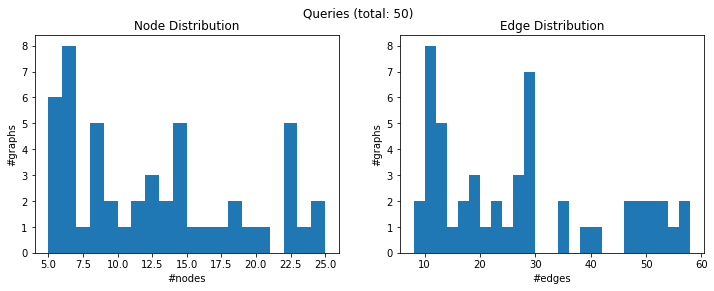

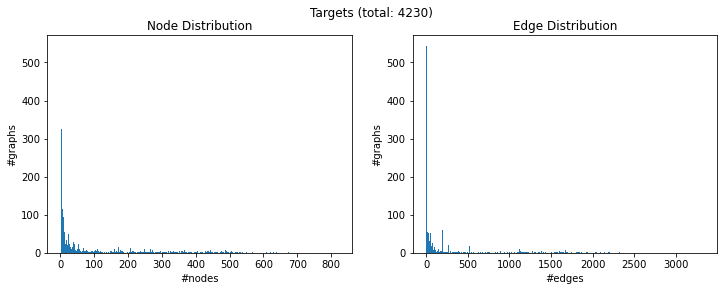

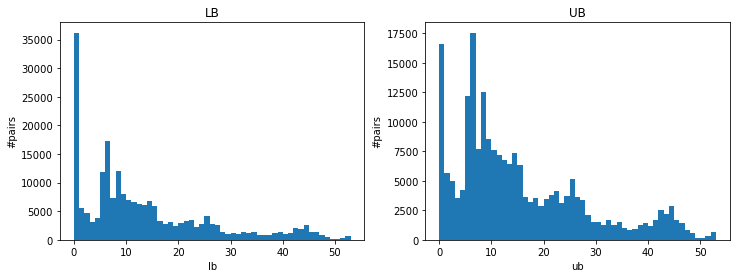

In [6]:
viz.plot_dataset_dist(outer_test_set)

In [7]:
def rank_metrics(fn, lb, ub, preds, ylabel, title, percent=True):
    k = torch.arange(1, 21, 1)
    plt.figure()
    Ys = []
    for label, pred in preds:
        Y = fn(k, lb, ub, pred)
        viz.plot_summary(k, Y, show_std=False, label=label, lim=percent)
        Ys.append((Y, label))
    plt.legend()
    plt.xlabel('k')
    plt.ylabel(ylabel)
    plt.title(title)
    plt.show()
    
    for Y, label in Ys:
#         print(f'{label}', end='\n')
        Z = torch.mean(Y, dim=-1)
        for i in [1,5,10,15,20]:
            if percent:
                print(f'{Z[i-1].item()*100:.2f}', end=' / ' if i != 20 else '\n')
            else:
                print(f'{Z[i-1].item():.3f}', end=' / ' if i != 20 else '\n')
#         print()

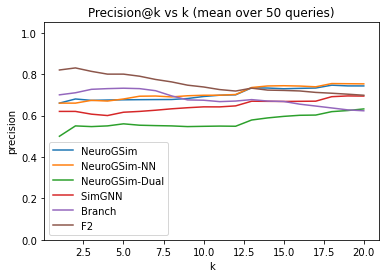

66.00 / 67.60 / 69.20 / 72.93 / 74.30
66.00 / 68.00 / 69.80 / 74.40 / 75.30
50.00 / 56.00 / 54.80 / 59.60 / 63.20
62.00 / 61.60 / 64.20 / 66.80 / 69.40
70.00 / 73.20 / 67.40 / 66.80 / 62.30
82.00 / 80.00 / 73.80 / 72.13 / 69.80


In [8]:
rank_metrics(metrics.precision_at_k, (lb+ub)/2, (lb+ub)/2, preds,
            'precision', f'Precision@k vs k (mean over {len(queries)} queries)')

In [14]:
for label, pred in preds:
#     print(f'{label}', end='\n')
    tmp = torch.mean(metrics.kendalls_tau_at_k(torch.tensor([20]), lb[:5], ub[:5], pred[:5])).item()
    print(f'{tmp*100:.2f}')
#     print()

96.21
97.26
94.74
97.05
81.89
80.63


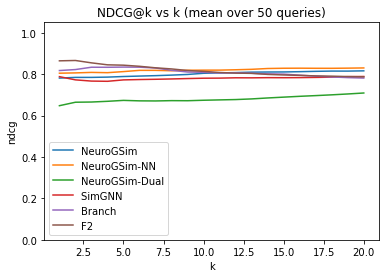

78.10 / 78.85 / 80.41 / 81.06 / 81.59
80.45 / 81.23 / 81.92 / 82.84 / 82.99
64.76 / 67.32 / 67.39 / 68.89 / 70.89
78.78 / 77.22 / 78.03 / 78.27 / 78.86
81.73 / 83.40 / 80.89 / 80.00 / 78.11
86.42 / 84.32 / 81.34 / 79.60 / 78.68


In [15]:
rank_metrics(metrics.ndcg_at_k, lb, ub, preds,
            'ndcg', f'NDCG@k vs k (mean over {len(queries)} queries)')

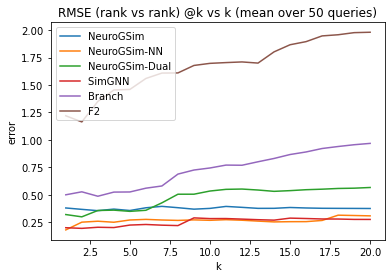

0.380 / 0.357 / 0.376 / 0.384 / 0.375
0.180 / 0.270 / 0.268 / 0.255 / 0.308
0.320 / 0.349 / 0.534 / 0.538 / 0.567
0.200 / 0.224 / 0.283 / 0.287 / 0.276
0.500 / 0.526 / 0.744 / 0.867 / 0.968
1.220 / 1.460 / 1.698 / 1.867 / 1.981


In [16]:
rank_metrics(metrics.rmse_at_k, lb, ub, preds,
            'error', f'RMSE (rank vs rank) @k vs k (mean over {len(queries)} queries)',
            percent=False)

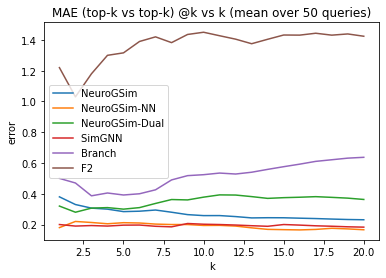

0.380 / 0.284 / 0.258 / 0.244 / 0.231
0.180 / 0.212 / 0.194 / 0.167 / 0.166
0.320 / 0.300 / 0.378 / 0.375 / 0.363
0.200 / 0.196 / 0.202 / 0.200 / 0.183
0.500 / 0.392 / 0.524 / 0.576 / 0.637
1.220 / 1.316 / 1.450 / 1.432 / 1.424


In [17]:
rank_metrics(metrics.error_at_k, lb, ub, preds,
            'error', f'MAE (top-k vs top-k) @k vs k (mean over {len(queries)} queries)',
            percent=False)